<a href="https://colab.research.google.com/github/SowjanyaSadashivu/CIFAR10/blob/main/Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from argparse import ArgumentParser
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.utils import download_url

In [ ]:
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


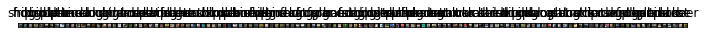

In [ ]:
def imshows(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    return npimg.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,12))
for idx,image in enumerate(images):
  axes[idx].imshow(imshows(image))
  axes[idx].set_title(classes[labels[idx]])
  axes[idx].set_xticks([])
  axes[idx].set_yticks([])

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


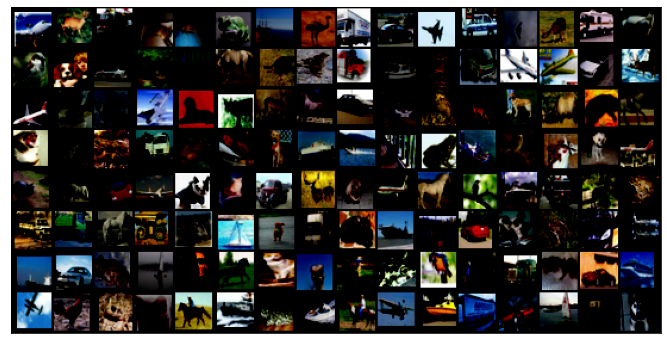

In [ ]:
show_batch(trainloader)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImgClassify(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class CNN(ImgClassify):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

In [ ]:
model = CNN()

In [ ]:
out = model(images)
   

In [ ]:
def get_default_device():
   
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
   
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
     
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
       
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(trainloader, device)
val_dl = DeviceDataLoader(testloader, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
         
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
      
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CNN(), device)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.10096914321184158, 'val_loss': 2.3028228282928467}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
weight_decay=0

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7392, test_loss: 1.4142, test_acc: 0.4629
Epoch [1], train_loss: 1.2277, test_loss: 1.0868, test_acc: 0.6075
Epoch [2], train_loss: 1.0069, test_loss: 0.9226, test_acc: 0.6721
Epoch [3], train_loss: 0.8426, test_loss: 0.8304, test_acc: 0.7036
Epoch [4], train_loss: 0.7401, test_loss: 0.7252, test_acc: 0.7488
Epoch [5], train_loss: 0.6555, test_loss: 0.6674, test_acc: 0.7693
Epoch [6], train_loss: 0.5987, test_loss: 0.6581, test_acc: 0.7767
Epoch [7], train_loss: 0.5537, test_loss: 0.6036, test_acc: 0.7948
Epoch [8], train_loss: 0.5178, test_loss: 0.5649, test_acc: 0.8064
Epoch [9], train_loss: 0.4877, test_loss: 0.5592, test_acc: 0.8129


In [ ]:
def predict_image(img, model):   
    xb = to_device(img.unsqueeze(0), device)    
    yb = model(xb)  
    _, preds  = torch.max(yb, dim=1)    
    return testset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cat , Predicted: cat


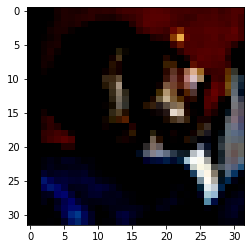

In [ ]:
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', testset.classes[label], ', Predicted:', predict_image(img, model))

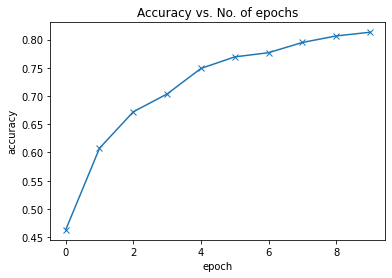

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)    

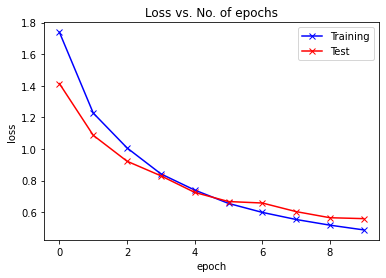

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Test'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)    

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:    
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on 10000 test images : %d %%' %( 100 * correct/total))    

Accuracy of the network on 10000 test images : 81 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    out = model(images)
    _, predicted = torch.max(out, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] +=1

for i in range(10):
  print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 75 %
Accuracy of   car : 96 %
Accuracy of  bird : 66 %
Accuracy of   cat : 73 %
Accuracy of  deer : 81 %
Accuracy of   dog : 81 %
Accuracy of  frog : 77 %
Accuracy of horse : 80 %
Accuracy of  ship : 90 %
Accuracy of truck : 84 %
